In [4]:
from __future__ import absolute_import,division,print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [6]:
#数据地址
dataset_path = "data/auto-mpg/auto-mpg.data"

In [9]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path,names= column_names,
                          na_values = "?",comment="\t",sep=" ",
                          skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
dataset = dataset.dropna()

In [12]:
origin = dataset.pop('Origin')

In [13]:
dataset['USA'] = (origin ==1) * 1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan']=(origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


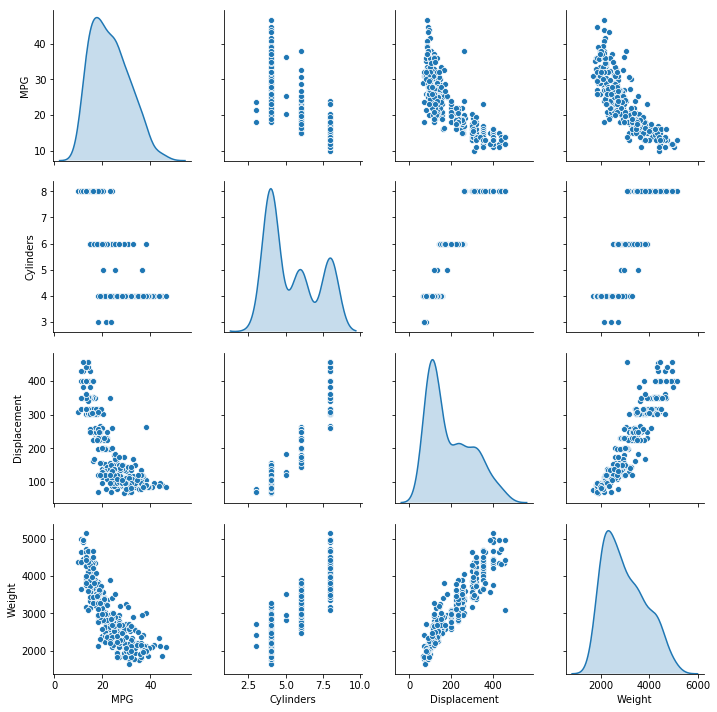

In [15]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],diag_kind="kde")

In [16]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [17]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [18]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [21]:
#normed_train_data.tail() 
normed_test_data.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
369,-0.869348,-0.798593,-0.442811,-0.705359,0.875068,1.660094,0.774676,-0.465148,-0.495225
375,-0.869348,-0.865687,-0.810302,-1.197124,-0.092942,1.660094,-1.286751,2.143005,-0.495225
382,-0.869348,-0.836932,-0.915299,-0.883106,0.480693,1.660094,-1.286751,-0.465148,2.012852
384,-0.869348,-0.999874,-0.994047,-1.214899,0.050467,1.660094,-1.286751,-0.465148,2.012852
396,-0.869348,-0.721914,-0.679055,-0.432815,1.090181,1.660094,0.774676,-0.465148,-0.495225


In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64,activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
        layers.Dense(64,activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',optimizer=optimizer,
                 metrics=['mean_absolute_error','mean_squared_error'])
    return model

model = build_model()
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16278106],
       [-0.06924209],
       [ 0.12471048],
       [-0.21698399],
       [ 0.1116631 ],
       [-0.02387998],
       [ 0.16828924],
       [ 0.21485361],
       [ 0.02134493],
       [ 0.12600344]], dtype=float32)

In [25]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0:
            print('')
        
        print('.',end='')
        
        
EPOCHS = 1000
history = model.fit(
    normed_train_data,train_labels,
    epochs=EPOCHS,validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()]
)

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.351004,0.991920,2.351004,8.691058,2.285796,8.691057,995
996,2.472469,1.039187,2.472469,8.442716,2.223252,8.442716,996
997,2.397736,1.011880,2.397736,8.152795,2.142725,8.152795,997
998,2.441038,0.998265,2.441038,10.110722,2.500067,10.110723,998
999,2.487006,1.026799,2.487006,8.320204,2.186067,8.320204,999


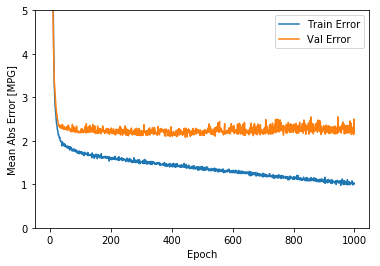

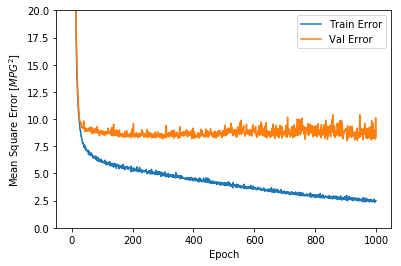

In [27]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'],hist['val_mean_absolute_error'],
            label='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'],hist['mean_squared_error'],
            label='Train Error')
    plt.plot(hist['epoch'],hist['val_mean_squared_error'],
            label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
    
plot_history(history)


.....................................................................

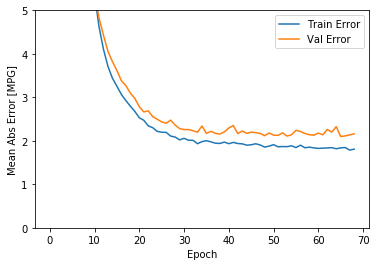

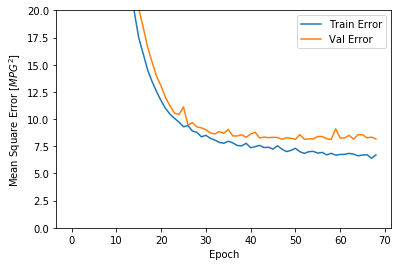

In [28]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data,train_labels,epochs=EPOCHS,
                   validation_split = 0.2,verbose=0,callbacks=[early_stop,PrintDot()]
                   )

plot_history(history)

In [29]:
loss,mae,mse = model.evaluate(normed_test_data,test_labels,verbose=0)
print("Testing set Mean Abs Error:{:5.3f} MPG".format(mae))
print("loss :",loss)

Testing set Mean Abs Error:1.859 MPG
loss : 5.704929657471486


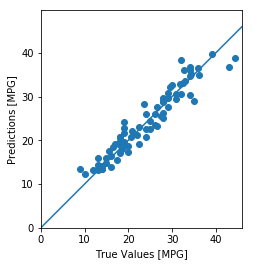

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

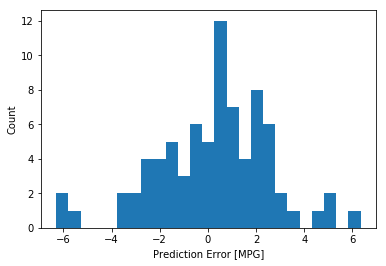

In [31]:
error = test_predictions - test_labels
plt.hist(error,bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")